# Tutorial for FedLab users

This is a comprehensive tutorial for users who would like to know FedLab. FedLab is built on the top of [torch.distributed](torch.distributed) modules and provides the necessary modules for FL simulation, including communication, compression, model optimization, data partition, and other functional modules. FedLab users can build FL simulation environment with custom modules like playing with LEGO bricks. 

In this tutorial, we will further describe the architecture of FedLab and its usage. To put it simply, we introduce FedLab by implementing a vanilla federated learning algorithm FedAvg in this file.

In [1]:
import sys
sys.path.append("../")

# configuration
from munch import Munch
from fedlab.models.mlp import MLP

model = MLP(784, 10)
args = Munch

args.total_client = 100
args.alpha = 0.5
args.seed = 42
args.preprocess = True
args.cuda = False

## 1. Prepare your dataset

FedLab provide necessary module for uses to patition their datasets. Additionally, various implementation of datasets partition for federated learning are also availiable at the [URL](https://github.com/SMILELab-FL/FedLab/tree/master/fedlab/dataset).

In [2]:
# We provide a example usage of patitioned MNIST dataset
# Download raw MNIST dataset and partition them according to given configuration

from torchvision import transforms
from fedlab.contrib.dataset.partitioned_mnist import PartitionedMNIST

fed_mnist = PartitionedMNIST(root="../datasets/mnist/",
                         path="../datasets/mnist/fedmnist/",
                         num_clients=args.total_client,
                         partition="noniid-labeldir",
                         dir_alpha=args.alpha,
                         seed=args.seed,
                         preprocess=args.preprocess,
                         download=True,
                         verbose=True,
                         transform=transforms.Compose(
                             [transforms.ToPILImage(), transforms.ToTensor()]))

dataset = fed_mnist.get_dataset(0) # get the 0-th client's dataset
dataloader = fed_mnist.get_dataloader(0, batch_size=128) # get the 0-th client's dataset loader with batch size 128

## 2. Define client local training

Client training procedure is implemented by class ClientTrainer in FedLab. We have built-in FedAvg implementation in FedLab.

In [3]:
# client
from fedlab.contrib.algorithm.basic_client import SGDSerialClientTrainer, SGDClientTrainer

# local train configuration
args.epochs = 5
args.batch_size = 128
args.lr = 0.1

trainer = SGDSerialClientTrainer(model, args.total_client, cuda=args.cuda) # serial trainer
# trainer = SGDClientTrainer(model, cuda=True) # single trainer

trainer.setup_dataset(fed_mnist)
trainer.setup_optim(args.epochs, args.batch_size, args.lr)

## 3. Define server global aggregation

In [4]:
# server
from fedlab.contrib.algorithm.basic_server import SyncServerHandler

# global configuration
args.com_round = 10
args.sample_ratio = 0.1

handler = SyncServerHandler(model=model, global_round=args.com_round, sample_ratio=args.sample_ratio, cuda=args.cuda)

## 4. Choose simulation mode and run

We provide three basic simulation mode in FedLab. Depending on the needs of users.

1. Choose Standalone mode to run the simulation with lowest resourch allocation.
2. Choose Cross-process mode to run the simulation with multi-machines or multi-gpus with faster calculation.
3. Chosse Hierachical mode to run the simulation across computer clusters.

### Standalone

We provide an example pipeline implementation. Please see [URL](https://github.com/SMILELab-FL/FedLab/blob/master/fedlab/core/standalone.py).

If you change the data partition paramters $\alpha$, you could get following convergence curves, which reavels the Non-IID challenge in federated learning.

![](./examples/imgs/non_iid_impacts_on_fedavg.jpg)

Round 0, Loss 21.8655, Test Accuracy 0.2819
Round 1, Loss 16.8743, Test Accuracy 0.4256
Round 2, Loss 11.4556, Test Accuracy 0.6736
Round 3, Loss 9.7989, Test Accuracy 0.6655
Round 4, Loss 8.1740, Test Accuracy 0.7111
Round 5, Loss 7.3797, Test Accuracy 0.7431
Round 6, Loss 6.5602, Test Accuracy 0.7709
Round 7, Loss 5.8442, Test Accuracy 0.8077
Round 8, Loss 4.9822, Test Accuracy 0.8531
Round 9, Loss 4.6129, Test Accuracy 0.8608


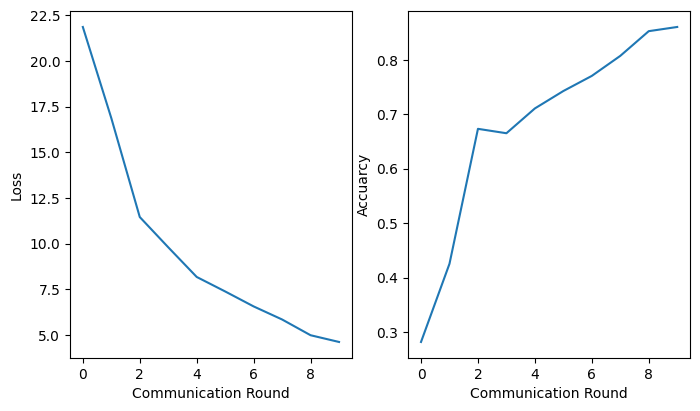

In [5]:
import matplotlib.pyplot as plt
import numpy as np

from fedlab.utils.functional import evaluate
from fedlab.core.standalone import StandalonePipeline

from torch import nn
from torch.utils.data import DataLoader
import torchvision

class EvalPipeline(StandalonePipeline):
    def __init__(self, handler, trainer, test_loader):
        super().__init__(handler, trainer)
        self.test_loader = test_loader 
        self.loss = []
        self.acc = []
        
    def main(self):
        t=0
        while self.handler.if_stop is False:
            # server side
            sampled_clients = self.handler.sample_clients()
            broadcast = self.handler.downlink_package
            
            # client side
            self.trainer.local_process(broadcast, sampled_clients)
            uploads = self.trainer.uplink_package

            # server side
            for pack in uploads:
                self.handler.load(pack)

            loss, acc = evaluate(self.handler.model, nn.CrossEntropyLoss(), self.test_loader)
            print("Round {}, Loss {:.4f}, Test Accuracy {:.4f}".format(t, loss, acc))
            t+=1
            self.loss.append(loss)
            self.acc.append(acc)
    
    def show(self):
        plt.figure(figsize=(8,4.5))
        ax = plt.subplot(1,2,1)
        ax.plot(np.arange(len(self.loss)), self.loss)
        ax.set_xlabel("Communication Round")
        ax.set_ylabel("Loss")
        
        ax2 = plt.subplot(1,2,2)
        ax2.plot(np.arange(len(self.acc)), self.acc)
        ax2.set_xlabel("Communication Round")
        ax2.set_ylabel("Accuarcy")
        
        
test_data = torchvision.datasets.MNIST(root="../datasets/mnist/",
                                       train=False,
                                       transform=transforms.ToTensor())
test_loader = DataLoader(test_data, batch_size=1024)

standalone_eval = EvalPipeline(handler=handler, trainer=trainer, test_loader=test_loader)
standalone_eval.main()

standalone_eval.show()

### Cross-process

Due to the jupyter doesn't support multi-process program, we provide only the description of Cross-process mode and Hierachical mode in this part.

For runable scripts, please see our examples in [cross-process](https://github.com/SMILELab-FL/FedLab/tree/master/examples/cross-process-mnist) and [scale](https://github.com/SMILELab-FL/FedLab/tree/master/examples/scale-mnist).

In [6]:
from fedlab.core import DistNetwork
from fedlab.core.client.manager import PassiveClientManager

# Client side. Put your trainer into a network manager.

args.ip = "127.0.0.1"
args.port = 3002
args.rank = 1
args.world_size = 2 # world_size = the number of client manager + 1 (server)

args.ethernet = None

client_network = DistNetwork(
    address=(args.ip, args.port),
    world_size=args.world_size,
    rank=args.rank,
    ethernet=args.ethernet,
)

# trainer can be ordinary trainer or serial trainer.
client_manager = PassiveClientManager(trainer=trainer,
                                network=client_network)

# Server side. Put your handler into a network manager.
from fedlab.core.server import SynchronousServerManager

server_network = DistNetwork(address=(args.ip, args.port),
                      world_size=args.world_size,
                      rank=0, # the rank of server is 0 as default
                      ethernet=args.ethernet)

server_manager = SynchronousServerManager(handler=handler,
                                    network=server_network,
                                    mode="GLOBAL")

### Hierachical

Hierachical is a complex network topology implementation in FedLab. Hierarchical mode for FedLab is designed for situation tasks on multiple computer clusters (in different LAN) or the real-world scenes. To enable the inter-connection for different computer clusters, FedLab develops Scheduler as middle-server process to connect client groups. Each Scheduler manages the communication between the global server and clients in a client group. And server can communicate with clients in different LAN via corresponding Scheduler. The computation mode of a client group for each scheduler can be either standalone or cross-process.

A hierarchical FL system with K client groups is depicted as below. For a runable scripts, please see [here](https://github.com/SMILELab-FL/FedLab/tree/master/examples/hierarchical-hybrid-mnist)

![](./docs/imgs/fedlab-hierarchical.svg)